## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 7 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

## Loading Libraries And Data For Colombia Cemetos Argos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Colombia - Cementos Argos SA (C')

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,5150,5100,5170,5100,212.44K,0.0098
1,2021-03-30 00:00:00,5100,5010,5100,5010,583.70K,0.0109
2,2021-03-29 00:00:00,5045,5020,5045,5015,117.54K,0.0050
3,2021-03-26 00:00:00,5020,5085,5085,4980,203.46K,-0.0020
4,2021-03-25 00:00:00,5030,5035,5045,4950,317.06K,0.0010


In [ ]:
df.shape

(304, 7)

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
299,2020-01-08 00:00:00,6880,6940,6950,6880,84.93K,-0.0101
300,2020-01-07 00:00:00,6950,6950,6950,6850,168.71K,-0.0071
301,2020-01-03 00:00:00,7000,7040,7100,6960,470.77K,-0.0169
302,2020-01-02 00:00:00,7120,7300,7300,7120,138.96K,-0.0247
303,"Highest: 7,300.0","Lowest: 2,415.0","Difference: 4,885.0","Average: 4,836.5",Change %: -29.5,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

## Data Wrangling

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def convert_volume(x):
    if x.endswith('K'):
        return float(x[:-1]) * 1000
    elif x.endswith('M'):
        return float(x[:-1]) * 1000000
    else:
        return float(x)

In [ ]:
df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype(float)

## Exploratory Data Analysis

In [ ]:
df['Price'].describe()

count     303.000000
mean     4836.544554
std      1025.407096
min      2420.000000
25%      3900.000000
50%      4801.000000
75%      5770.000000
max      7120.000000
Name: Price, dtype: float64

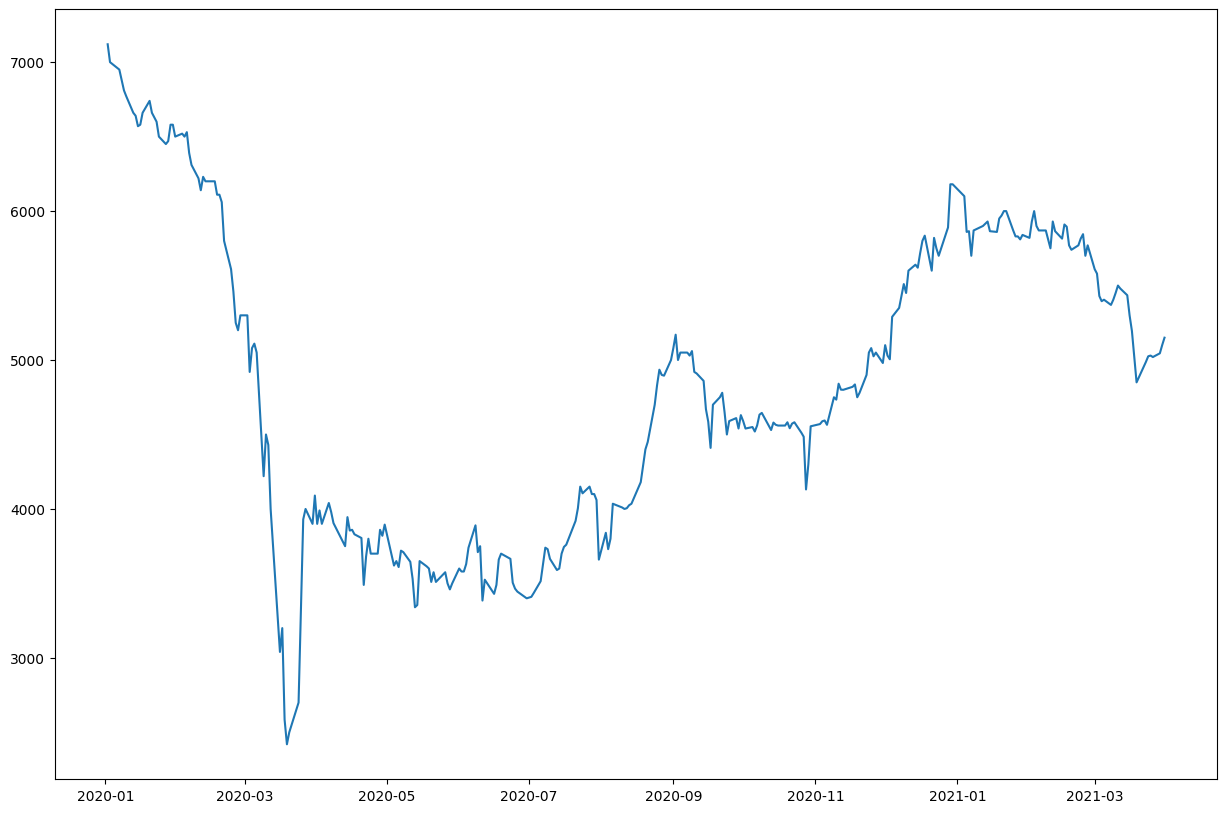

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['Price'])
plt.show()

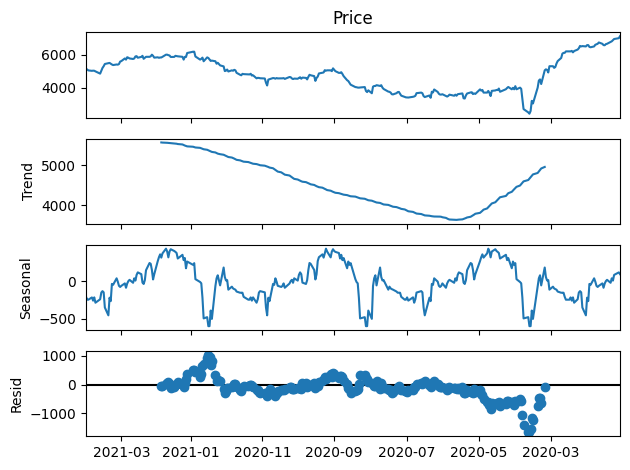

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
decomp.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

ADF Statistic: -0.569834
p-value: 0.877654
Critical Values:


In [ ]:
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')
stationarity_check(result[1])

Data is Non-Stationary


## Modeling and Preprocessing

In [ ]:
df['price_diff'] = df['Price'].diff()
df.dropna(inplace=True)

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df.dropna(inplace=True)

In [ ]:
result = adfuller(df['rolling_mean_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])


ADF Statistic: -3.093438
p-value: 0.027043
Critical Values: {'1%': -3.4537536300652, '5%': -2.8718443180148836, '10%': -2.572260641818822}


In [ ]:
stationarity_check(result[1])

Data is Stationary


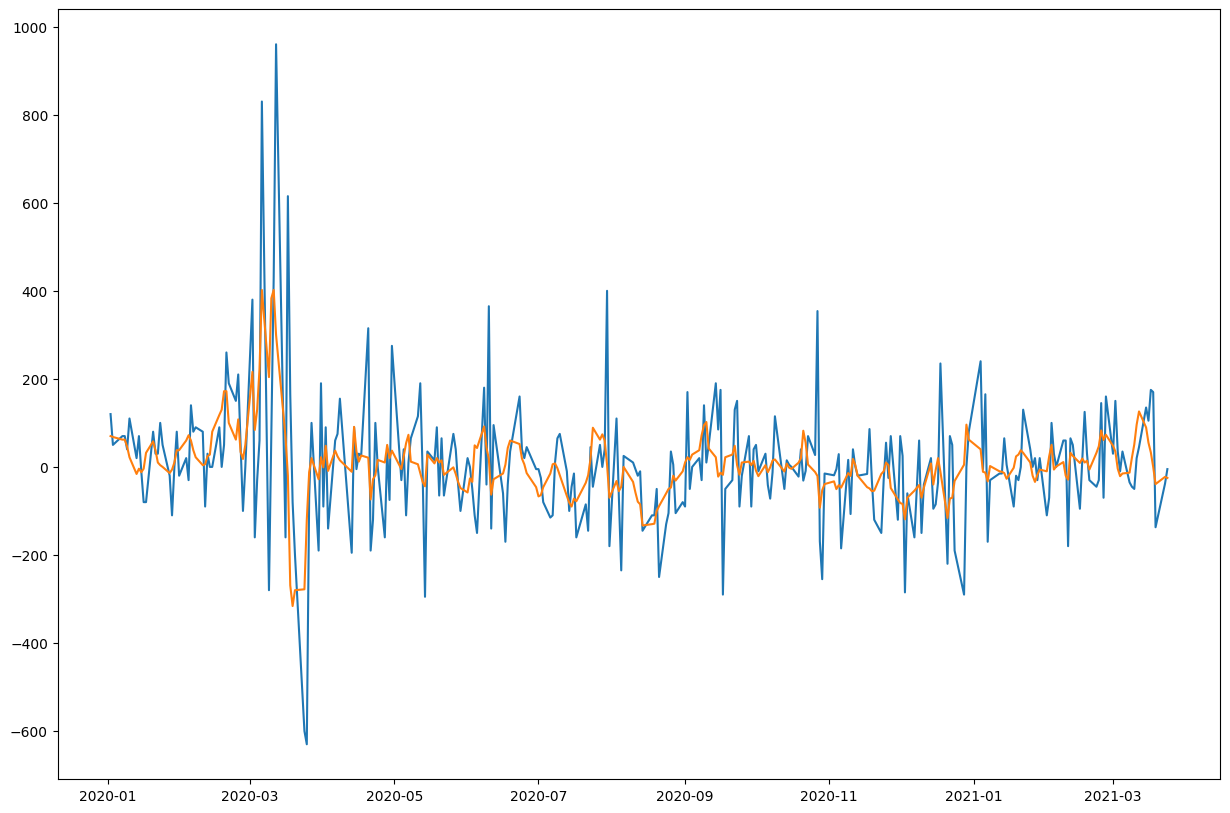

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['price_diff'])
plt.plot(df['rolling_mean_diff'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_train = df['2020-01-01':'2021-01-01']
df_test = df['2021-01-01':]


## Creating The ARIMA Model

In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean_diff'].values, df_test['rolling_mean_diff'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

## Finding The Best Order For ARIMA Model

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
#evaluate_models(df_train['price_diff'].values, p_values, d_values, q_values)

In [ ]:
p = 2
d = 1
q = 2
model = ARIMA(df_train['rolling_mean_diff'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

## Plotting The Fitted ARIMA Model

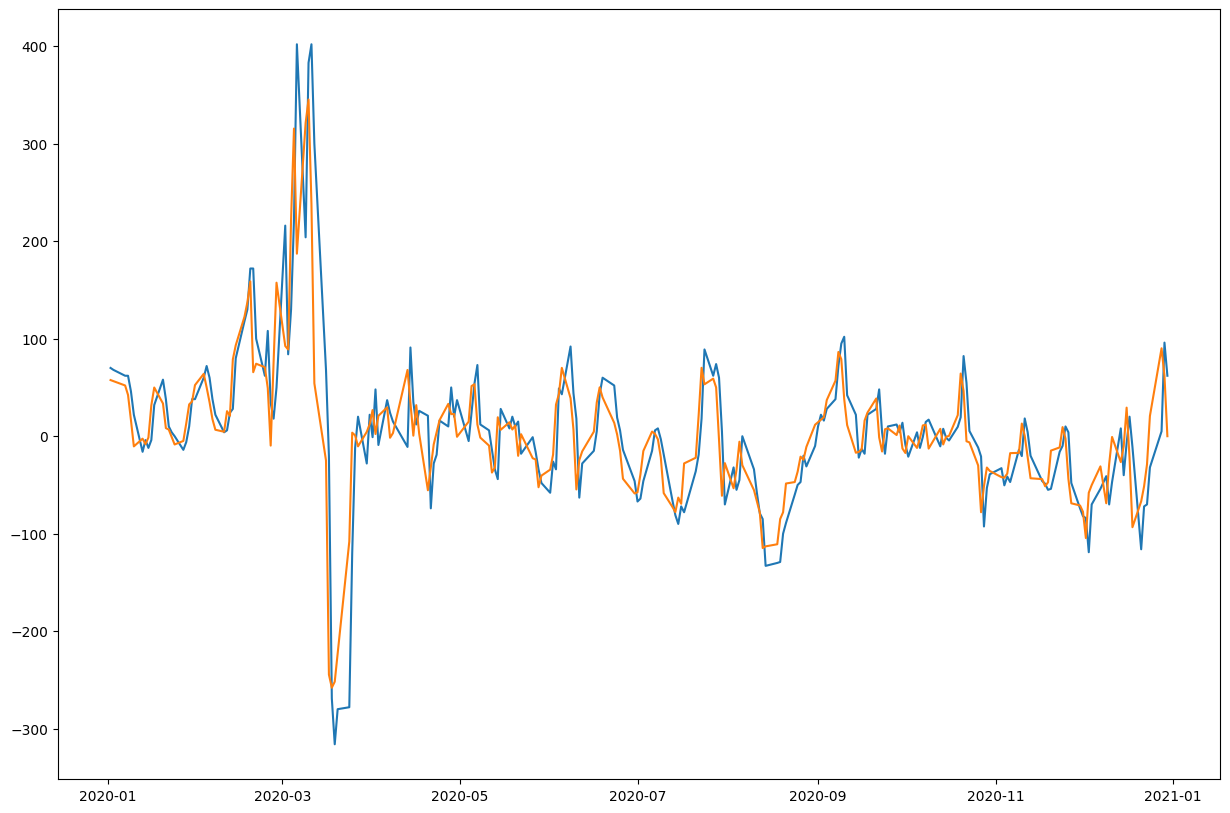

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

## Plotting Forecasts

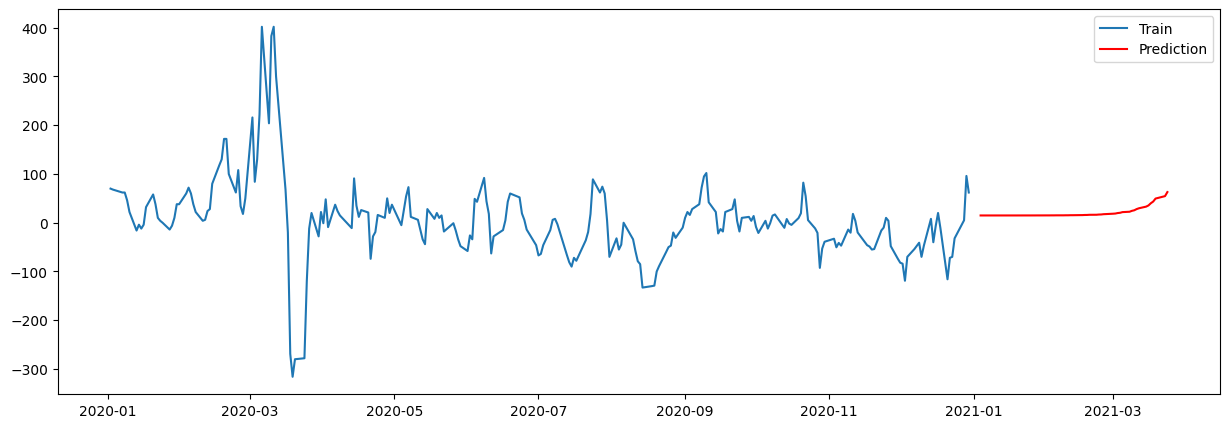

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mpe = mean_absolute_percentage_error(data[start_train_size:], predictions)

    return mse , mpe, predictions

In [ ]:
mse, mpe, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 1, 1), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-04,71.873164
2021-01-05,33.530408
2021-01-06,-2.214546
2021-01-07,-20.012118
2021-01-08,-25.900432


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

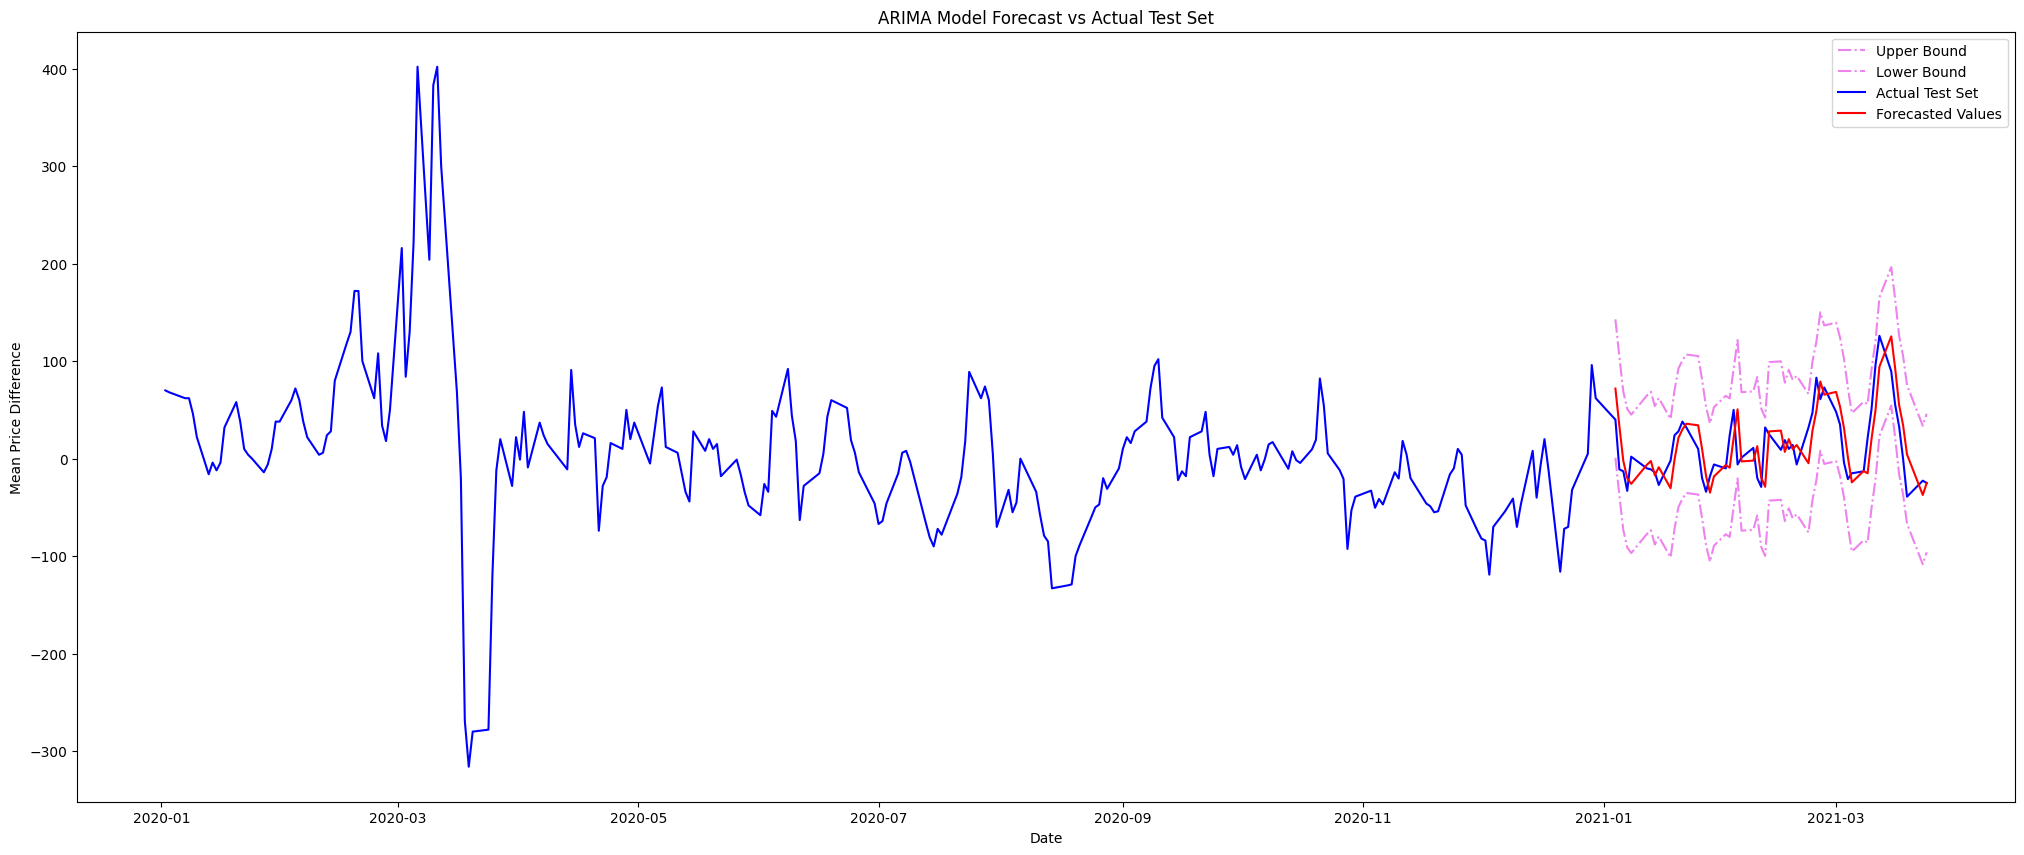

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Mean Price Difference')
plt.legend()
plt.show()

In [ ]:
o_std = df['rolling_mean_diff'].std()

## Decisions: Buy, Sell, Hold

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'sell'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1).head(30)

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head(30)

,Decision,Open
2021-01-04,hold,5000.0
2021-01-05,hold,5020.0
2021-01-06,hold,5025.0
2021-01-07,buy,5195.0
2021-01-08,hold,5310.0
2021-01-12,hold,5435.0
2021-01-13,hold,5500.0
2021-01-14,hold,5510.0
2021-01-15,hold,5450.0
2021-01-18,hold,5530.0


## Assessing Profit Based On Decision Parameters

In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

0